## Determine which population each population-specific trancript is actually population specific to

In [25]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.getcwd())
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [26]:
config = load_config()
od = '../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

In [27]:
min_samples = 2
min_cpm = 0.1
min_tau = 0.8
tau_df = pd.read_csv(f'241023_{min_cpm}_{min_samples}tau.tsv', sep='\t')
tau_df['tau_pop_spec_t'] = tau_df.tau>=min_tau
tau_df_back = tau_df.copy(deep=True)

In [43]:
# get median expression per population
# because this is what the value is computed based on 
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

# get the median expression value across samples from the same populations
# using the median because we want to remove the effect 
# of individual samples expression patterns on the analysis
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index':'sample'}, axis=1, inplace=True)
df = df.merge(meta[['sample', 'population']], 
              how='left', on='sample')
df = df.groupby('population').median().reset_index()
# df = df.groupby('population').mean().reset_index()
df.set_index('population', inplace=True)
df.index.name = ''
df = df.transpose()

max_vals = df.max(axis=1)
max_pops = df.idxmax(axis=1)
max_count = (df == max_vals[:, None]).sum(axis=1)

df_copy = df.copy(deep=True)
df_copy[df.eq(max_vals, axis=0)] = float('NaN')
second_max_value = df_copy.max(axis=1)
second_max_column = df_copy.idxmax(axis=1)

df_copy = df.copy(deep=True)
df_copy[df.eq(max_vals, axis=0)] = float('NaN')
df_copy[df.eq(second_max_value, axis=0)] = float('NaN')
third_max_value = df_copy.max(axis=1)
third_max_column = df_copy.idxmax(axis=1)


df['max_val'] = max_vals
df['max_pop'] = max_pops
df['max_count'] = max_count
df['2_max_val'] = second_max_value
df['2_max_pop'] = second_max_column
df['3_max_val'] = third_max_value
df['3_max_pop'] = third_max_column
df['max_diffs'] = df['max_val']-df['2_max_val']
df['2_max_diffs'] = df['max_val']-df['3_max_val']

# remove all with >1 max count
n = len(df.loc[(df.max_count>1)&(df.max_count!=8)].index)
if n > 0: 
    print(f'Warning: found {n} transcripts with duplicate median exp. values across pops')
df = df.loc[df.max_count==1]



df.reset_index(inplace=True)
df.rename({'index':'tid'}, axis=1, inplace=True)
df.head()

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


,tid,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI,max_val,max_pop,max_count,2_max_val,2_max_pop,3_max_val,3_max_pop,max_diffs,2_max_diffs
0,transcript_6675,0.299724,0.172414,0.357418,0.550844,0.385320,0.706408,0.651034,0.435400,0.706408,MPC,1,0.651034,PEL,0.550844,ITU,0.055374,0.155564
1,transcript_6676,0.982259,0.540054,0.309999,0.456469,0.431042,0.569546,0.532116,0.697418,0.982259,AJI,1,0.697418,YRI,0.569546,MPC,0.284841,0.412713
2,transcript_6684,0.433248,0.441766,0.460381,0.688555,0.366190,0.639539,0.600679,0.388386,0.688555,ITU,1,0.639539,MPC,0.600679,PEL,0.049016,0.087876
3,transcript_6687,0.034472,0.000000,0.027777,0.000000,0.000000,0.059861,0.051411,0.000000,0.059861,MPC,1,0.051411,PEL,0.034472,AJI,0.008450,0.025389
4,transcript_11363,0.430140,0.709061,0.596585,0.322114,0.196753,0.432933,0.289803,0.470983,0.709061,CEU,1,0.596585,HAC,0.470983,YRI,0.112476,0.238078


## Plot tau vs. 1' 2' differences

In [47]:
df.loc[df.tid=='transcript_10290']

,tid,AJI,CEU,HAC,ITU,LWK,MPC,PEL,YRI,max_val,max_pop,max_count,2_max_val,2_max_pop,3_max_val,3_max_pop,max_diffs,2_max_diffs
15,transcript_10290,0.0,0.0,0.0,0.0,0.0,0.101643,0.0,0.0,0.101643,MPC,1,0.0,AJI,NaN,NaN,0.101643,NaN


In [45]:
tau_df = tau_df_back.loc[tau_df_back['tau_pop_spec_t'] ==True]
tau_df = tau_df.merge(df[['max_val', 'max_pop', 'tid',
                          '2_max_val','2_max_pop','max_diffs',
                          '3_max_val', '3_max_pop', '2_max_diffs']],
                          how='left', on='tid')

In [46]:
tau_df.head()

,tid,tau,tau_pop_spec_t,max_val,max_pop,2_max_val,2_max_pop,max_diffs,3_max_val,3_max_pop,2_max_diffs
0,ENST00000688680.1,0.875000,True,8.558890e-02,CEU,0.000000e+00,AJI,8.558890e-02,NaN,NaN,NaN
1,transcript_10288,0.856244,True,4.835730e-07,LWK,6.886100e-08,MPC,4.147120e-07,3.697520e-09,ITU,4.798755e-07
2,transcript_10290,0.875000,True,1.016433e-01,MPC,0.000000e+00,AJI,1.016433e-01,NaN,NaN,NaN
3,transcript_12302,0.814873,True,1.109003e-01,AJI,5.189050e-02,MPC,5.900985e-02,0.000000e+00,CEU,1.109003e-01
4,ENST00000367024.5,0.875000,True,5.714200e-02,MPC,0.000000e+00,AJI,5.714200e-02,NaN,NaN,NaN


Text(0.5, 0.98, "Tau vs. log(1' 2' expression)")

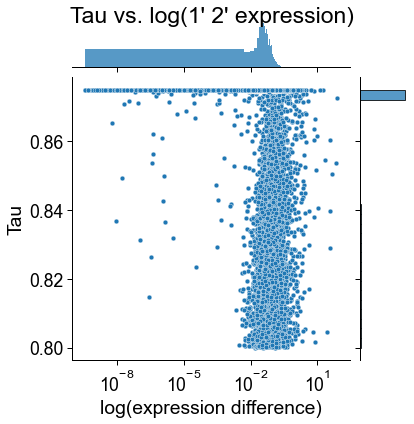

In [40]:
# relationship between difference in median CPM of 1' and 2' highest epxressed
# population per transcript vs. the tau value
g = sns.jointplot(tau_df, x='max_diffs', y='tau')
ax = g.ax_joint
ax.set(ylabel='Tau',
       xlabel='log(expression difference)',
       xscale='log')

g.fig.suptitle("Tau vs. log(1' 2' expression)")

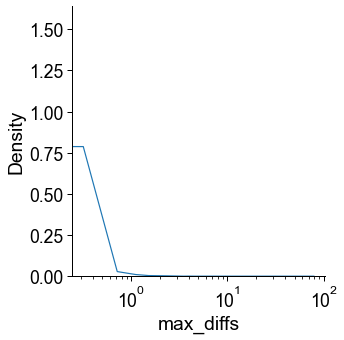

In [42]:
ax = sns.displot(tau_df, 
            x='max_diffs',
            kind='kde')
ax.set(xscale='log')

Text(0.5, 0.98, "Tau vs. log(1' 3' expression)")

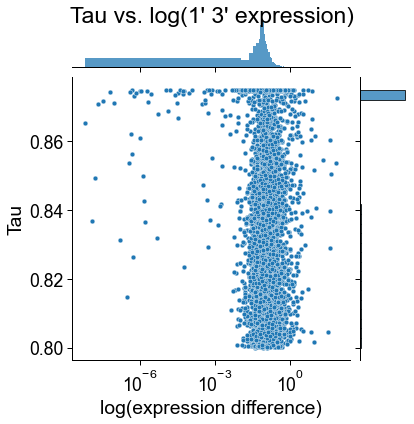

In [48]:
# relationship between difference in median CPM of 1' and 2' highest epxressed
# population per transcript vs. the tau value
g = sns.jointplot(tau_df, x='2_max_diffs', y='tau')
ax = g.ax_joint
ax.set(ylabel='Tau',
       xlabel='log(expression difference)',
       xscale='log')

g.fig.suptitle("Tau vs. log(1' 3' expression)")

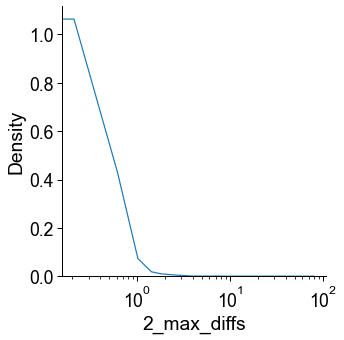

In [49]:
ax = sns.displot(tau_df, 
            x='2_max_diffs',
            kind='kde')
ax.set(xscale='log')

## pop-specific transcripts max. median values

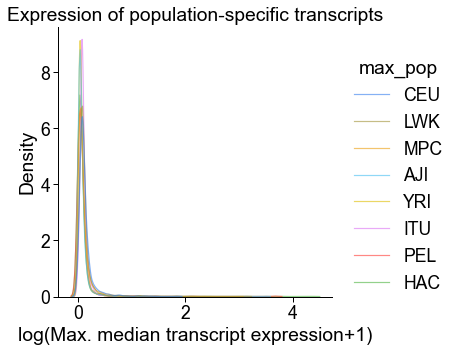

In [63]:
# merge w/ population its spec in
tau_df = tau_df_back.loc[tau_df_back['tau_pop_spec_t'] ==True]
tau_df = tau_df.merge(df[['max_val', 'max_pop', 'tid']], 
             how='left', on='tid')
tau_df['log_max_val'] = np.log(tau_df.max_val+1)

tau_df.head()
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
ax = sns.displot(tau_df, 
            x='log_max_val',
            hue='max_pop',
            palette=c_dict,
            alpha=0.6,
            kind='kde',
            common_norm=False)

ax.set(xlabel='log(Max. median transcript expression+1)',
       title='Expression of population-specific transcripts')

## Recreate the pop-specif detection plot

In [64]:
# merge w/ population its spec in
tau_df = tau_df_back.loc[tau_df_back['tau_pop_spec_t'] ==True]
tau_df = tau_df.merge(df[['max_val', 'max_pop', 'tid']], 
             how='left', on='tid')

In [65]:
tau_df.head()

,tid,tau,tau_pop_spec_t,max_val,max_pop
0,ENST00000688680.1,0.875000,True,8.558890e-02,CEU
1,transcript_10288,0.856244,True,4.835730e-07,LWK
2,transcript_10290,0.875000,True,1.016433e-01,MPC
3,transcript_12302,0.814873,True,1.109003e-01,AJI
4,ENST00000367024.5,0.875000,True,5.714200e-02,MPC


In [66]:
# get structural categories
## what structural categories are high-tau transcripts?
mt_df = pd.read_csv('../data/05_mastertable/master_table.tsv', sep='\t')
mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)

,associated_transcriptid.v,trx_per_asstrx_count_antisense,trx_per_asstrx_count_full-splice_match,trx_per_asstrx_count_fusion,trx_per_asstrx_count_genic,trx_per_asstrx_count_incomplete-splice_match,trx_per_asstrx_count_intergenic,trx_per_asstrx_count_novel_in_catalog,trx_per_asstrx_count_novel_not_in_catalog,associated_geneid.v,...,start,end,strand,discovered_transcripts_per_gene,old_associated_geneid.v,old_associated_gene_biotype,existsFSMinGene,existsFSMinTranscript,filter,pop_spec_t
0,ENST00000741439.1,0,1,0,0,0,0,0,0,ENSG00000296732.1,...,83370,130598,+,27,ENSG00000296732.1,lncRNA,True,True,pass,False
1,ENST00000741409.1,0,1,0,0,0,0,0,0,ENSG00000296732.1,...,83375,199915,+,27,ENSG00000296732.1,lncRNA,True,True,pass,False
3,ENST00000741433.1,0,1,0,0,1,0,0,0,ENSG00000296732.1,...,83409,157166,+,27,ENSG00000296732.1,lncRNA,True,True,pass,False
4,ENST00000741423.1,0,1,0,0,0,0,0,0,ENSG00000296732.1,...,83392,173640,+,27,ENSG00000296732.1,lncRNA,True,True,pass,False
5,ENST00000741425.1,0,0,0,0,1,0,0,0,ENSG00000296732.1,...,83351,88840,+,27,ENSG00000296732.1,lncRNA,True,False,pass,False


In [68]:
tau_df = tau_df.merge(mt_df[['isoform', 'structural_category']],
                      how='left',
                      left_on='tid',
                      right_on='isoform')

In [73]:
# replace all NANs w/ FSM because thats what they are 
# TODO fix this when have the new sqanti thing
tau_df['structural_category'] = tau_df['structural_category'].fillna('FSM')

In [77]:
temp = tau_df[['tid', 'structural_category',
        'max_pop']].groupby(['structural_category', 'max_pop'], dropna=False).count()

In [79]:
temp = temp.reset_index()
temp.head()

,structural_category,max_pop,tid
0,Antisense,AJI,25
1,Antisense,CEU,13
2,Antisense,HAC,25
3,Antisense,ITU,11
4,Antisense,LWK,14


In [95]:
def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

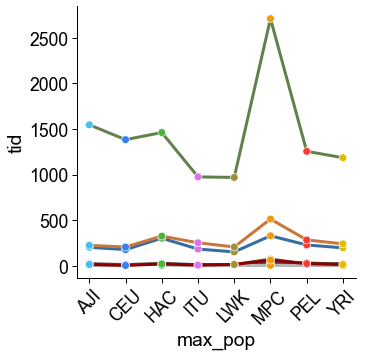

In [96]:
init_plot_settings()
c_dict, order = get_novelty_colors()
ax = sns.lineplot(temp,
    x='max_pop', y='tid', hue='structural_category',
    palette=c_dict, linewidth=3, legend=None)
c_dict, order = get_population_colors()
sns.scatterplot(temp, x='max_pop', y='tid', hue='max_pop',
    palette=c_dict, ax=ax, zorder=3,
    s=60,legend=None)
clean_figure(ax)            

## limted just to pop-spec expressed transcripts

In [5]:
tau_df = tau_df_back.loc[tau_df_back['tau_pop_spec_t'] ==True]
tau_df = tau_df.merge(df[['max_val', 'max_pop', 'tid']], 
             how='left', on='tid')

In [6]:
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
temp = tau_df[['max_pop', 'tid']].groupby('max_pop').nunique().reset_index()
temp.head()

,max_pop,tid
0,AJI,2024
1,CEU,1797
2,HAC,2164
3,ITU,1446
4,LWK,1371


[Text(0.5, 0, ''), Text(0, 0.5, '# population-specific transcripts')]

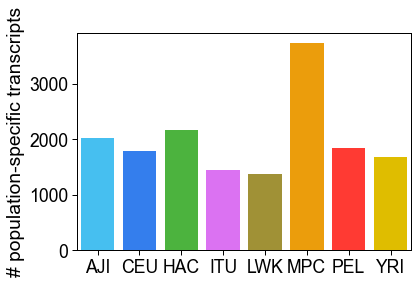

In [7]:
# number of pop-spec transcirpts / pop
ax = sns.barplot(temp, x='max_pop', y='tid',
            palette=c_dict, order=order,
           saturation=1) 
ylabel = '# population-specific transcripts'
xlabel = ''
ax.set(xlabel=xlabel, ylabel=ylabel)

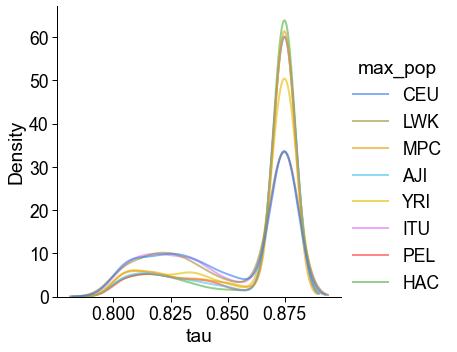

In [8]:
# are taus higher / lower for differnet pop spec transcripts 
# depending on the pop?
sns.displot(tau_df, kind='kde', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            common_norm=False, 
            linewidth=2,
            alpha=0.6)

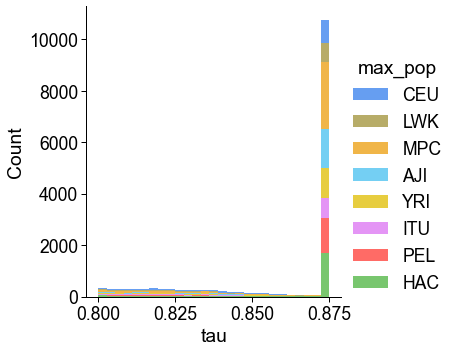

In [9]:
sns.displot(tau_df, kind='hist', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            multiple='stack', linewidth=False)

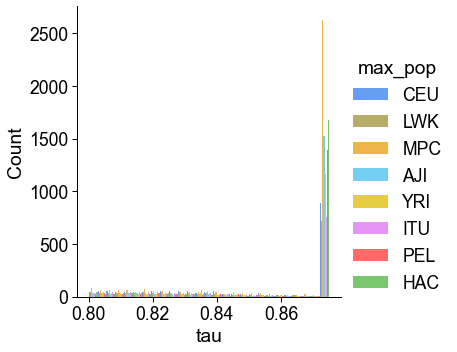

In [10]:
sns.displot(tau_df, kind='hist', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            multiple='dodge', linewidth=False)

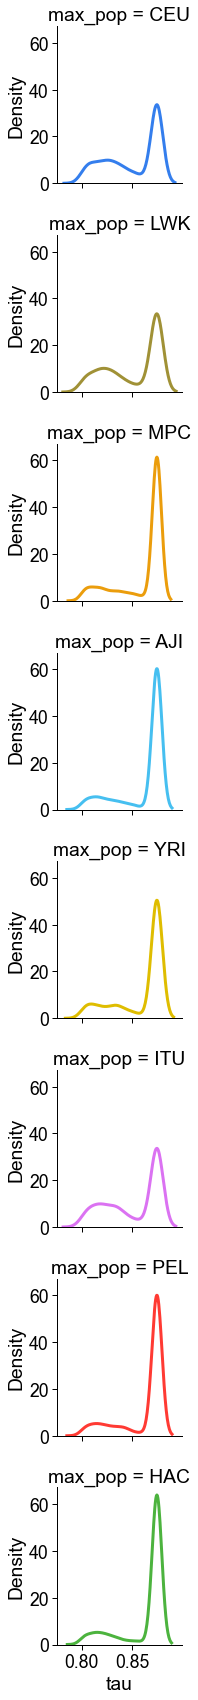

In [11]:
init_plot_settings('square')
g = sns.FacetGrid(tau_df, row='max_pop')
g.map_dataframe(sns.kdeplot, x='tau',
                hue='max_pop', palette=c_dict,
                linewidth=3)

## any transcript

In [12]:
## any transcript that is most median most highly-expressed in one pop or another
tau_df = tau_df_back.merge(df[['max_val', 'max_pop', 'tid']], 
             how='left', on='tid')

[Text(0.5, 0, ''), Text(0, 0.5, '# population-specific transcripts')]

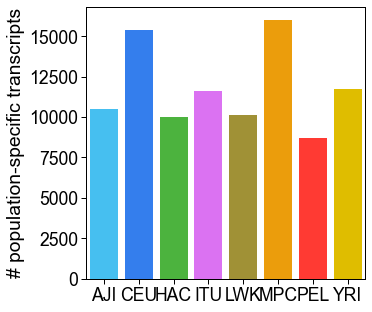

In [13]:
# number of highest-expresseed transcirpts / pop
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
temp = tau_df[['max_pop', 'tid']].groupby('max_pop').nunique().reset_index()
temp.head()
ax = sns.barplot(temp, x='max_pop', y='tid',
            palette=c_dict, order=order,
           saturation=1) 
ylabel = '# population-specific transcripts'
xlabel = ''
ax.set(xlabel=xlabel, ylabel=ylabel)

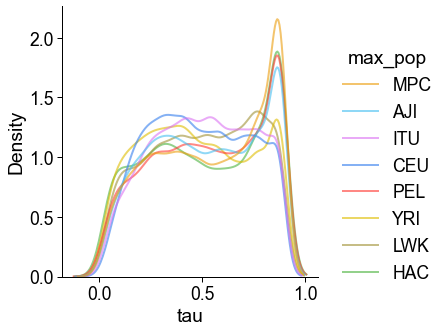

In [14]:
# are taus higher / lower for differnet pop spec transcripts 
# depending on the pop?
sns.displot(tau_df, kind='kde', 
            palette=c_dict, 
            hue='max_pop', 
            x='tau',
            common_norm=False, 
            linewidth=2,
            alpha=0.6)

In [15]:
tau_df.head()

,tid,tau,tau_pop_spec_t,max_val,max_pop
0,transcript_6675,0.324285,False,0.706408,MPC
1,transcript_6676,0.355661,False,0.982259,AJI
2,transcript_6684,0.228488,False,0.688555,ITU
3,transcript_6687,0.635436,False,0.059861,MPC
4,transcript_11363,0.342149,False,0.709061,CEU


## what if we just care about transcripts that are expressed at all in each pop?

In [16]:
# get median expression per population
# because this is what the value is computed based on 
f = expand(proc_cfg(config['lr']['kallisto']['quant']['merge_matrix_tpm_tsv'],od))[0]

meta = load_meta()
meta = meta.loc[meta.merged_run_mode==True]
sample_d = dict([(entry.cell_line_id, entry['sample']) \
                 for ind, entry in meta.iterrows()])


df = pd.read_csv(f, sep='\t')
df.columns = [d if d == 'transcript_id' else d.split('_')[0] for d in df.columns]
df.rename({'transcript_id':'tid'}, axis=1, inplace=True)
df.rename(sample_d, axis=1, inplace=True)
df.set_index('tid', inplace=True)

# get the median expression value across samples from the same populations
# using the median because we want to remove the effect 
# of individual samples expression patterns on the analysis
df = df.transpose()
df.reset_index(inplace=True)
df.rename({'index':'sample'}, axis=1, inplace=True)
df = df.merge(meta[['sample', 'population']], 
              how='left', on='sample')
df = df.groupby('population').median().reset_index()
# df = df.groupby('population').mean().reset_index()
df.set_index('population', inplace=True)
df.index.name = ''
df = df.transpose()


# expressed = above min cpm
df = df>=min_cpm

# get only expresesd transcript + population pairs
df = df.melt(ignore_index=False, value_name='expressed', var_name='pop')
df = df.loc[df.expressed==True]
df.reset_index(inplace=True)
df.rename({'index':'tid'}, axis=1, inplace=True)

In [17]:
# merge w/ tau df
tau_df = tau_df_back.merge(df, how='inner', on='tid')

In [18]:
tau_df.head()

,tid,tau,tau_pop_spec_t,pop,expressed
0,transcript_6675,0.324285,False,AJI,True
1,transcript_6675,0.324285,False,CEU,True
2,transcript_6675,0.324285,False,HAC,True
3,transcript_6675,0.324285,False,ITU,True
4,transcript_6675,0.324285,False,LWK,True


[Text(0.5, 0, ''),
 Text(0, 0.5, '# population-expressed\n(med. CPM>=0.1 transcripts')]

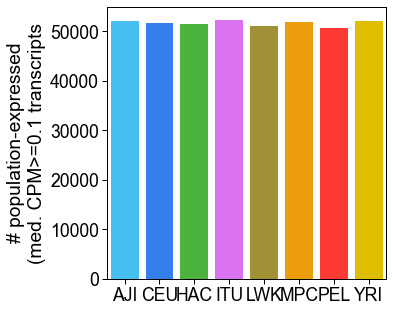

In [19]:
# number of highest-expresseed transcirpts / pop
init_plot_settings(aspect='square')
c_dict, order = get_population_colors()
temp = tau_df[['pop', 'tid']].groupby('pop').nunique().reset_index()
temp.head()
ax = sns.barplot(temp, x='pop', y='tid',
            palette=c_dict, order=order,
           saturation=1) 
ylabel = f'# population-expressed\n(med. CPM>={min_cpm} transcripts'
xlabel = ''
ax.set(xlabel=xlabel, ylabel=ylabel)

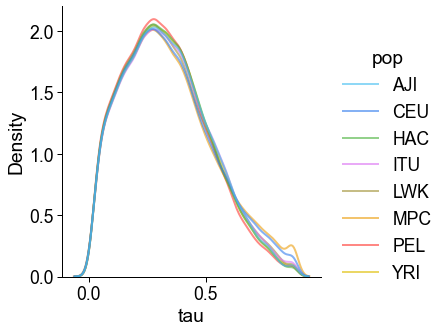

In [20]:
# are taus higher / lower for differnet pop spec transcripts 
# depending on the pop?
sns.displot(tau_df, kind='kde', 
            palette=c_dict, 
            hue='pop', 
            x='tau',
            common_norm=False, 
            linewidth=2,
            alpha=0.6)